# Bayesian optimization,bandits and Thompson sampling

Notebook putting the excellent Machine lectures of Nando de Freitas in code/(LA)tex(t). We are dealing with Bayesian optimization,bandits and Thompson sampling in particular. Slides on http://www.cs.ubc.ca/~nando/540-2013/lectures/l7.pdf

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import Image
from bayes_opt import BayesianOptimization # pip install bayesian-optimization

# path to png's
PATH = 'C:\\Users\\Egbert\\datascience\\ubc_ml\\tut_png\\bayesian_learning\\'

A “one-armed bandit” is a somewhat antiquated term for a slot machine, which tends to “rob” players of their money. The colorful name for our problem comes from a motivating story in which a gambler
enters a casino and sits down at a slot machine with multiple levers, or arms, that can be pulled.
When pulled, an arm produces a random payout drawn independently of the past. Because the
distribution of payouts corresponding to each arm is not listed, the player can learn it only by
experimenting. As the gambler learns about the arms’ payouts, she faces a dilemma: in the
immediate future she expects to earn more by exploiting arms that yielded high payouts in the
past, but by continuing to explore alternative arms she may learn how to earn higher payouts
in the future. Can she develop a sequential strategy for pulling arms that balances this tradeoff
and maximizes the cumulative payout earned? 

The success probabilities (θ1, .., θK) are unknown to the agent, but are fixed over time, and therefore can be learned by experimentation. Based on 2 observations we can fit a Gaussian through those 2 data points:

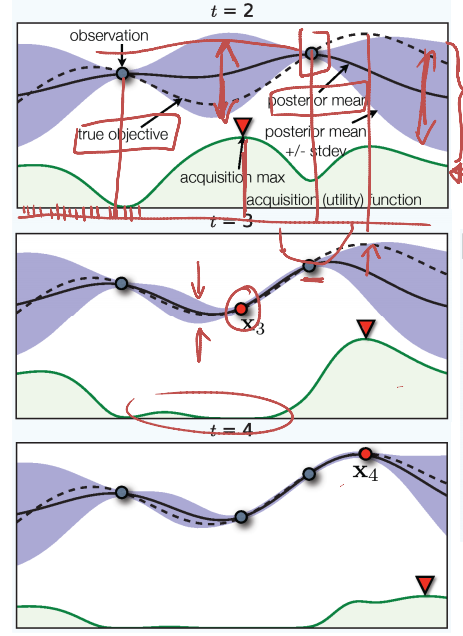

In [2]:
Image(PATH + 'bandits.png', width = 600)

We assume the function is smooth and we would fit a Gaussian. The mission is to find where the peak of the function occurs (upper pic the straight red line departing from the dotted true function line). Another mechanism we need is to have a way to decide which points to take next (The green 'acquisition-function' line can give us a good indication because it decides how the data can be 'acquired', thereby trading off **'exploration'** vs **'exploitation'**. Since the second blue point has a higher reward as compared to point A, we should look near point B. In order to decide which points to explore, we use the confidence bands. 

If we choose a point a point where the confidence intervals are the widest (much uncertainty), this is where we gain most information. We just basically need to know the maximum of the confidence interval values. Drawing a new point at x=3, I refit my Gaussian process. In the second picture, if we'd repeat the process, we'd draw at the red triangle position. High-over, this is **Bayesian optimization** :

**Exploration-Exploitation trade-off - (EE)** is a fundamental dilemma between choosing what you know and getting something close to what you expect ('exploitation') and choosing something you are not sure about and possibly learn more ('exploration'). Optimal learning requires that you sometimes make bad choices.

Recall the expression for the GP predictions:

If you want to make a prediction and we have data $D_{1:t}$, and a new test point $x_{t+1}$, our prediction is Gaussian and has 2 stats: mean and variance. 

$\underset{prediction}{P(Y_{t}+ 1} \rvert \mathcal{D}_{1:t}, \underset{test}{X_{t+1}} = \mathcal{N}(\mu_{t}(X_{t+1}), \sigma_{t}^{2}(X_{t+1})+ \sigma_{noise}^{2})$

$\mu_{t}(X_{t+1}) = k^{T}[K + \sigma_{noise}^{2}I]^{-1}Y_{1:t}$

$\sigma^{2}_{t}(X_{t+1}) = k(x_{t+1},k(x_{t+1}) - k^{T}[K + \sigma_{noise}^{2}I]^{-1}k$

We should choose the next point x where the mean is high (exploitation) and the variance is high (exploration). We can balance this EE trade-off with the acquisition function:

$\mu(x) + \mathcal{K}\sigma(x)$

If you think that high variance is more important (we're in exploration modus), you would choose a trade-off parameter (kappa K) to be very large, if we'd think the mean is more important, we'd choose a small value for K.

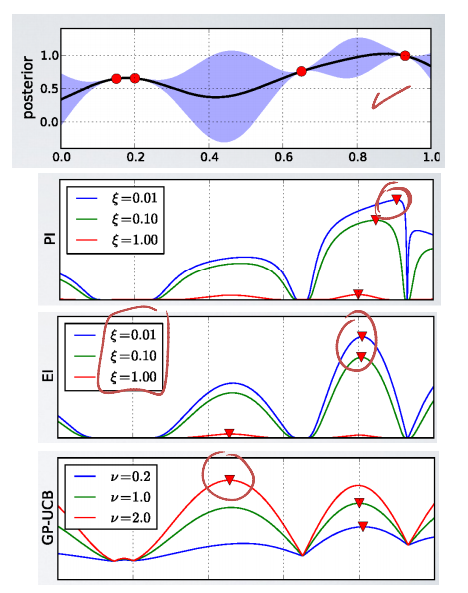

In [3]:
Image(PATH + 'acquisition_functions.png', width =600)

### Acquisition functions

- 1) PI =  **Probability of Improvement** 

$PI(x) = P(f(x) \geqslant \mu^{+} + \epsilon)$ 

$\Phi(\frac{\mu(x) - \mu^{+} - \epsilon}{\sigma(x)})$

where $\mu_{+}$ is the best observed value and $f^{max} = \mu^{+} + \epsilon$, $\Phi$ is the cumulative for the AUC.

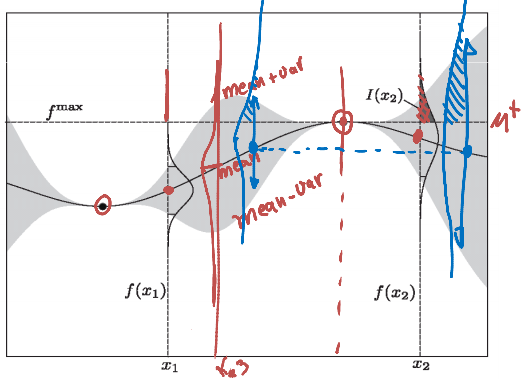

In [4]:
Image(PATH + 'probability_of_improvement.png', width=600)

Assuming samplings at the red-encircled points P1, P2, a GP is fitted. The black line is the $\mu$ of GP and grey confidence bounds represent the GP variance. Using PI, the criteria that we'll use for EE will be to look at the AUC of the Gaussian that has width implied by sigma and that is located at the mean. Off course X2 has a much higher AUC compared to X1. 

- 2) EP =  **Expected Improvement** 

First define the term **Expected utility criterion** : at iteration n+1, choose the point that minimizes the distance to the objective evaluated at the maximum $x_{*}$. Let's assume we know the true function and that $x_{*}$ is the location of the maximum.

$X_{n+1} = \underset{x}{argmin} \hspace{1mm}\mathbb{E}(\underset{GP}{\rVert\mathcal{f}_{n+1}(x)} - \underset{true function}{\mathcal{f}(x^{*})}\rVert \hspace{1mm} \rvert \mathcal{D}_{n})$ 

Our mission is to find the X (regardless of what the GP function is) that would minimize the difference between the function and the actual true function. By integrating over f, we say, regardless of what f is, we want to be as close to $x_{*}$ as possible. The catch is we don't know the true function and to overcome this, Mockus, proposed the following function: 

$x = \underset{x}{argmax} \hspace{1mm} \mathbb{E}(max \{ 0, \mathcal{f}_{n+1}(x) - \mathcal{f}^{max} \} \rvert \mathcal{D}_{n})$

For this expected improvement, we can obtain an analytical expression:

$EI_{x} = \begin{cases}
(\mu(x) - \mu^{'} - \epsilon) \Phi (\mathcal{Z}) + \sigma(x)\phi(\mathcal{Z}),  & if \sigma(x) > 0 \\
0, & if \sigma(x) = 0
\end{cases}$

$Z = \frac{\mu(x)- \mu^{+}-\epsilon}{\sigma(x)}$

where $\phi(.)$ denotes the PDF of the Standard Normal
and where $\Phi$ denotes the the CDF of the Standard Normal

- 3) **GP- UCB (Upper Confidence Bounds)**

Here we define a notion of regret and cumulative regret as follows:

$r(x) = f(x^{*}) - f(x)$

$\mathcal{R}_{t} = r(X_{1}) + .. + r(X_{T})$

the GP=-UCB criterion is as follows:

$GP-UCB(x) = \mu(X) + \sqrt{v \beta_{t} \sigma(x)}$

where Beta is set using a simple concentration bound.

Let's see some code with the **'Bayesian optimization'** module: a pure Python implementation of bayesian global optimization with gaussian processes. https://github.com/fmfn/BayesianOptimization

### Target Function

Lets create a target 1-D function with multiple local maxima to test and visualize how the BayesianOptimization package works. The target function we will try to maximize is the following:
$$f(x) = e^{-(x - 2)^2} + e^{-\frac{(x - 6)^2}{10}} + \frac{1}{x^2 + 1}, $$
its maximum is at $x = 2$ and we will restrict the interval of interest to $x \in (-2, 10)$.
Notice that, in practice, this function is unknown, the only information we have is obtained by sequentially probing it at different points. Bayesian Optimization works by contructing a posterior distribution of functions that best fit the data observed and chosing the next probing point by balancing exploration and exploitation.

In [4]:
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

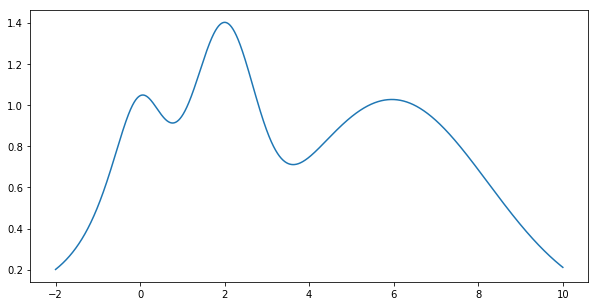

In [5]:
x = np.linspace(-2, 10, 10000).reshape(-1,1)
y = target(x)
fig, ax =plt.subplots(figsize= [10,5])
ax.plot(x,y);

In [6]:
# create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.
bo = BayesianOptimization(target, {'x': (-2, 10)})

In [7]:
bo.maximize(init_points=2, n_iter=0, acq='ucb', kappa=5)

Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |    1.03615 |   -0.0602 | 
    2 | 00m00s |    1.02097 |    6.2081 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 


In this example we will use the **Upper Confidence Bound (UCB) as our utility function**. It has the free parameter $\kappa$ controlling the EE trade-off. We will set $\kappa=5$ which, in this case, makes the algorithm quite bold. Additionally we will use the cubic correlation in our Gaussian Process.

### Plotting and visualizing the algorithm at each step

In [8]:
from matplotlib import gridspec

def posterior(bo, x, xmin=-2, xmax=10):
    xmin, xmax = -2, 10
    bo.gp.fit(bo.X, bo.Y)
    mu, sigma = bo.gp.predict(x, return_std=True)
    return mu, sigma

def plot_gp(bo, x, y):
    
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Gaussian Process and Utility Function After {} Steps'.format(len(bo.X)), fontdict={'size':30})
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    mu, sigma = posterior(bo, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(bo.X.flatten(), bo.Y, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility = bo.util.utility(x, bo.gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

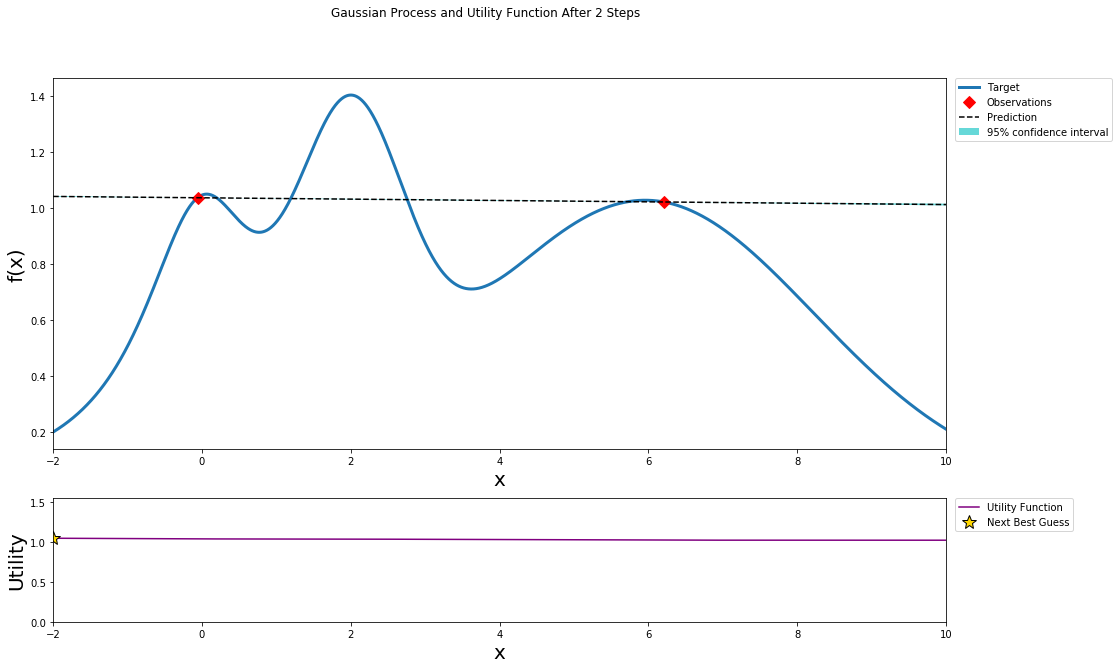

In [9]:
plot_gp(bo, x, y)

Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    3 | 00m03s |    0.20166 |   -2.0000 | 


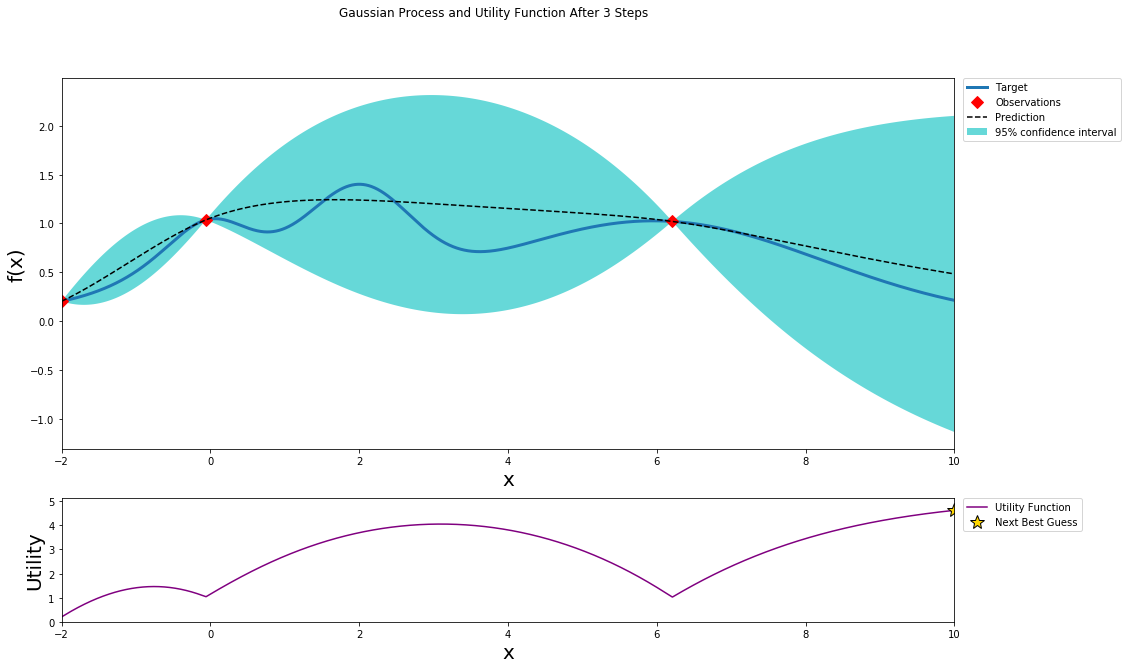

In [10]:
# run this again in a new cell to explore more steps
bo.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(bo, x, y)

Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    4 | 00m01s |    0.21180 |   10.0000 | 


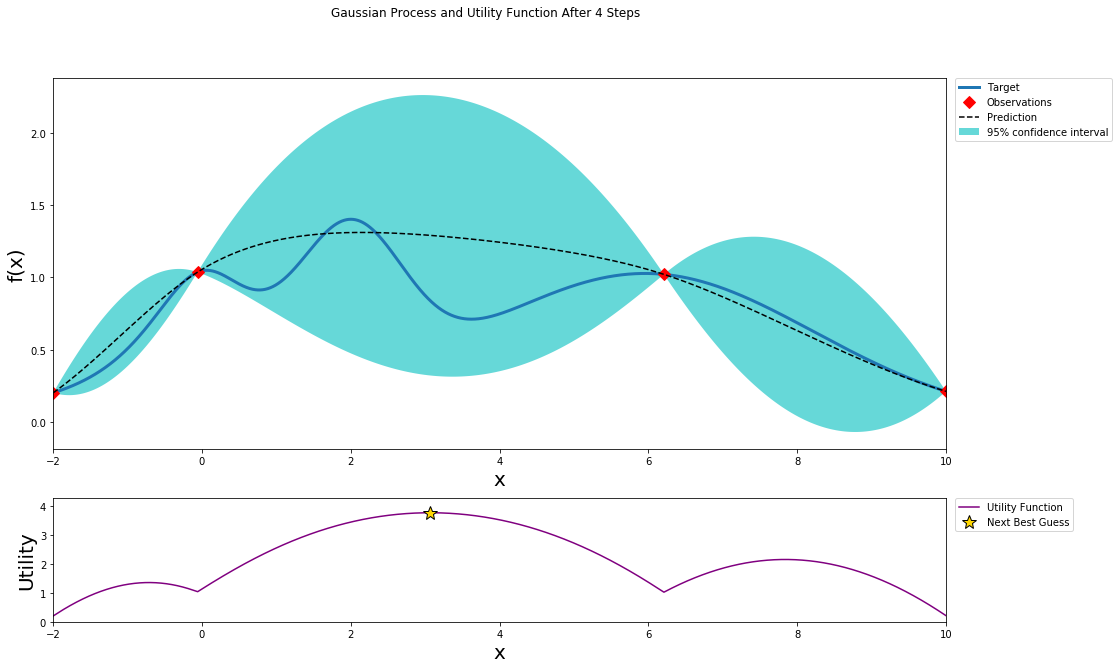

In [11]:
# run this again in a new cell to explore more steps
bo.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(bo, x, y)

### Thomson Sampling

Thompson sampling is an algorithm for online decision problems where actions are taken sequentially in a manner that must balance between exploiting what is known to maximize immediate performance and investing to accumulate new information that may improve future performance. (source: page 6 of  https://arxiv.org/abs/1707.02038)

Recall the Bernoulli bandit example. There are $K$ actions. When played, an action $K$ produces a reward of one with probability $\theta_{k}$ and a reward of zero with probability $1 - \theta_{k}$. Each $\theta_{k}$ can be interpreted as an action’s success probability or mean reward. The mean rewards $\theta = (\theta_{1}, ..., \theta_{K})$ are unknown, but fixed over time. In the first period, an action x1 is applied, and a reward $r_{1} ∈ {0, 1}$ is generated with success probability $P(r_{1} = 1 \rvert x_{1}, \theta) = \theta_{x1}$

After observing $r1$, the agent applies another action $x2$, observes a reward $r2$, and this
process continues. Let the agent begin with an independent prior belief over each $θ_{k}$. Take these
priors to be beta-distributed with parameters $α = (α_{1}, . . . , α_{K})$ and $β ∈ (β_{1}, . . . , β_{K})$.In particular, for each action $k$, the prior probability density function of $\theta_{k}$ is
$ p(\theta_{k}) = \frac {\Gamma(α_{k} + β_{k})} {\Gamma(α_{k}) \Gamma(β_{k})} \theta_{k}^{α_{k}^{-1}} (1 − \theta_{k})^{βk−1} $ 

where $\Gamma$ denotes the gamma function. As observations are gathered, the distribution is updated according to Bayes’ rule. It is particularly convenient to work with beta distributions because of their conjugacy properties. In particular, each action’s posterior distribution is also beta with parameters that can be updated according to a simple rule:

$(α_{k}, β_{k}) ← \begin{cases} (α_{k}, β_{k}) & if x_{t} = k \\
(α_{k}, β_{k}) + (r_{t}, 1 − r_{t}) & if x_{t} = k
\end{cases}$

Note that for the special case of $α_{k} = β_{k} = 1$, the prior $p(\theta_{k})$ is uniform over [0, 1]. Note that only the parameters of a selected arm are updated. The parameters $(α_{k}, β_{k})$ are sometimes called pseudo-counts, since $(α_{k}$ or $β_{k}$ increases by one with each observed success or failure, respectively. 

We want to use the power of conjugate priors and Thompson Sampling to easily update our belief about the true action value for each arm. In this scenario, we have 10 Bernoulli bandits, where each arm has a random chance p of rewarding us with 1 and a )1-p) chance of rewarding 0.

### Case: optimizing clicks 

https://www.chrisstucchio.com/blog/2013/bayesian_bandit.html

Imagine we want to show different online newspaper article title to different users and measure CTR. Let us represent each CTR by $\theta_{i}$ - the true probability that an individual user will click on the i-th title. We assume that these rates $\theta_{i}$ do not change over time. The bandit algorithm should display all possible titles to a random selection of users, and measure which titles are clicked on more frequently. Over time, it will use these observations to infer which articles have the higher CTR.

Let $\mathcal{N}$ be the possible story titles each with a CTR of $\theta_{i}$ for which we don't know the value but since we are following a Bayesian approach, we will construct a porbability distribution which represents our belief what the actual value of $\theta_{i}$ is. Imn the underlying pic we believe that .1 < CTR < .7

The AUC = probability that $\theta_{i}$ lies between points A and B: 

$P(a < \theta_{i} < b) = \int^{b}_{a} \mathcal{f}(x)dx$

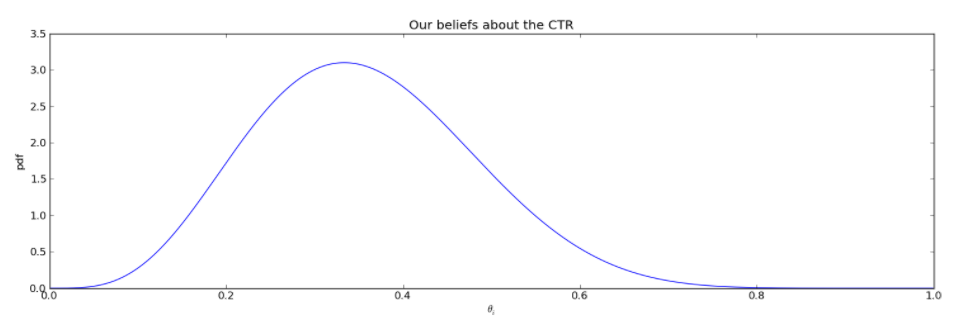

In [57]:
Image(PATH + 'bandits_ctr_1.png')

The basic idea behind Bayesian methods is to update our beliefs based on evidence. As we gather more data by showing different titles to other users and observing click throughs, we can incrementally narrow the width of the probability distribution.

First we need to choose a prior (what we believe to be true before we have any evidence). We can use a beta distribution as the prior:

$P(\theta_{i} = x) = \frac{x^{\alpha_{i}-1}(1-x)^{\beta_{i}-1}}{B(\alpha_{i}\beta_{i})} = \mathcal{f}_{\alpha_{i}\beta_{i}(x)}$

Where the term in the denominator, $B(\alpha_{i},\beta_{i})$ is present to act as a normalising constant so that the area under the PDF actually sums to 1.

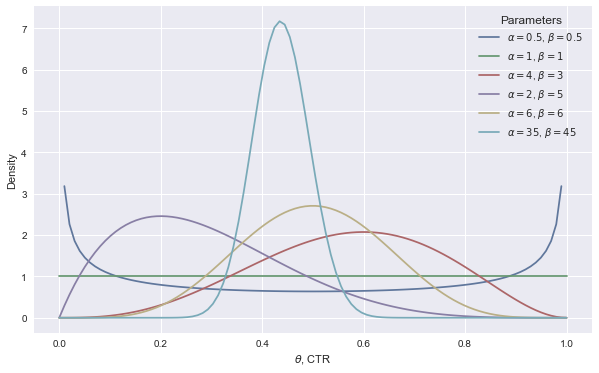

In [98]:
from scipy.stats import beta
fig, ax = plt.subplots(figsize= [10,6])
x = np.linspace(0, 1, 100)
params = [(0.5, 0.5), (1, 1), (4, 3), (2, 5),
          (6, 6) , (35,45)]
for p in params:
    y = stats.beta.pdf(x, p[0], p[1])
    ax.plot(x, y, label="$\\alpha=%s$, $\\beta=%s$" % p)
ax.set(xlabel = "$\\theta$, CTR", ylabel = "Density")
ax.legend(loc ='best', title="Parameters")

Essentially, as $\alpha$ becomes larger the bulk of the probability distribution moves towards the right (a coin biased to come up heads more often), whereas an increase in $\beta$ moves the distribution towards the left (a coin biased to come up tails more often). However, if both $\alpha$ and $\beta$ increase then the distribution begins to narrow.

**Conjugate Priors**

In Bayes' rule above we can see that the posterior distribution is proportional to the product of the prior distribution and the likelihood function:

$P(θ|D)∝P(D|θ)P(θ)$

A conjugate prior is a choice of prior distribution, that when coupled with a specific type of likelihood function, provides a posterior distribution that is of the same family as the prior distribution.

The prior and posterior both have the same probability distribution family, but with differing parameters.

** Optimizing click throughs**

Now that we have a method of representing our beliefs about CTRs, it is useful to construct an algorithm to identify the best ones. The ultimate goal of the bandit algorithm is to display to the user whichever title has the highest CTR. One method of estimating the CTRs of the articles is to **sample the posterior distribution**.

In [99]:
class BetaBandit(object):
    def __init__(self, num_options=2, prior=(1.0, 1.0)):
        self.trials = np.zeros(shape=(num_options,), dtype=int)
        self.successes = np.zeros(shape=(num_options,), dtype=int)
        self.num_options = num_options
        self.prior = prior

    def add_result(self, trial_id, success):
        self.trials[trial_id] = self.trials[trial_id] + 1
        if (success):
            self.successes[trial_id] = self.successes[trial_id] + 1

    def get_recommendation(self):
        sampled_theta = []
        for i in range(self.num_options):
            #Construct beta distribution for posterior
            dist = beta(self.prior[0] + self.successes[i],
                        self.prior[1] + self.trials[i] - self.successes[i])
            #Draw sample from beta distribution
            sampled_theta += [dist.rvs()]
        # Return the index of the sample with the largest value
        return sampled_theta.index(max(sampled_theta))

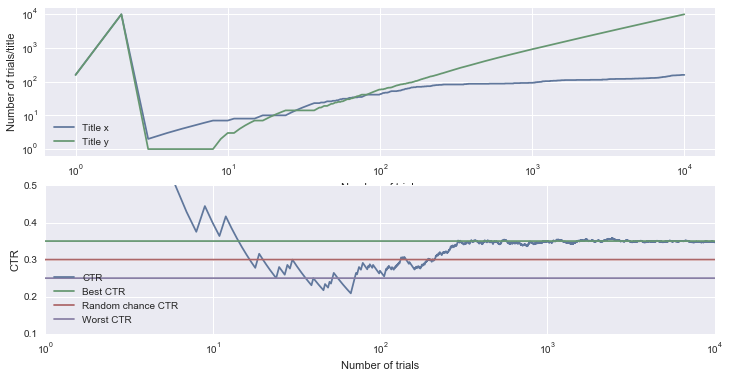

In [132]:
theta = (0.25, 0.35)

def is_conversion(title):
    if np.random.random() < theta[title]:
        return True
    else:
        return False

conversions = [0,0]
trials = [0,0]

N = 10000
trials = np.zeros(shape=(N,2))
successes = np.zeros(shape=(N,2))

bb = BetaBandit()
for i in range(N):
    choice = bb.get_recommendation()
    trials[choice] = trials[choice] + 1
    conv = is_conversion(choice)
    bb.add_result(choice, conv)

    trials[i] = bb.trials
    successes[i] = bb.successes
    
# plot
fig, ax = plt.subplots(2,1, figsize = [12,6])
n = np.arange(N) + 1
ax[0].loglog(n, trials[:,0], label="Title x")
ax[0].loglog(n, trials[:,1], label="Title y")
ax[0].legend()
ax[0].set(xlabel= "Number of trials", ylabel = "Number of trials/title")

ax[1].semilogx(n, (successes[:,0]+successes[:,1])/n, label="CTR")
ax[1].semilogx(n, np.zeros(shape=(N,))+ 0.35, label="Best CTR")
ax[1].semilogx(n, np.zeros(shape=(N,))+ 0.30, label="Random chance CTR")
ax[1].semilogx(n, np.zeros(shape=(N,))+ 0.25, label="Worst CTR")
plt.axis([0, N, 0.10, 0.50])
ax[1].set(xlabel = "Number of trials", ylabel = "CTR")
ax[1].legend(loc='best')

The bandit algorithm performs as it's supposed to: we simulated and fed the beta bandit 2 titles - title 'X', had a CTR of 0.25, title 'Y' had a CTR of 0.35. To start with, both titles were displayed to the user with roughly equal probability. Over time, evidence accumulated that title 1 was considerably better than title 0. At this point the algorithm switched to displaying primarily title 1, and the overall CTR of the experiment converged to 0.35 (the optimal CTR).

To finish: there is a nice simulation of a Bayesian bandit explorer here:https://learnforeverlearn.com/bandits/ and off course there is even an o'reilly' for it ;-)

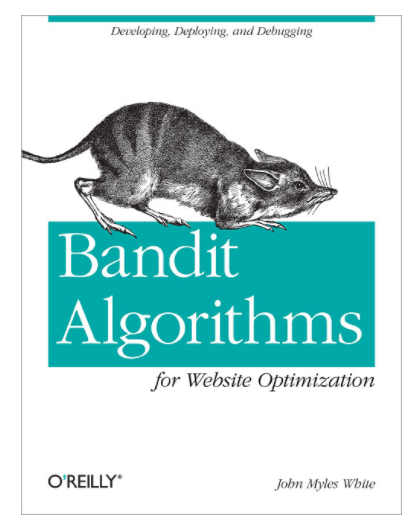

In [12]:
Image(PATH + 'bandit_algorithms_oreilly.png')